In [2]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


#1. Importar Librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import requests

In [4]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Crear funcion para Importar base Bitcoin

In [5]:
#Obtener df del Bitcoin
def df_bitcoin():
  ticker = "BTC-USD"
  start_date = pd.Timestamp.now() - pd.Timedelta(days=7)
  end_date = pd.Timestamp.now()
  df_bitcoin = yf.download(ticker, start=start_date, end=end_date, interval="5m")

  return df_bitcoin

#3. Crear funcion para extraer tendencias

In [6]:
def extraer_tendencias():
  
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'}
  url = "https://coinmarketcap.com/"
  response = requests.get(url, headers = headers)
  soup = BeautifulSoup(response.content, "html.parser")

  precio_actual = soup.find("div", {"class": "sc-cadad039-0 clgqXO"}).text.replace(",","").replace("$","")
  porcentaje = soup.find("span", {"class": "sc-97d6d2ca-0 bQjSqS"}).text
  precio_actual = float(precio_actual)

  # Análisis de tendencia a partir del icono up o down
  span_element = soup.find('span', {'class': ['icon-Caret-up', 'icon-Caret-down']})
  if 'icon-Caret-up' in span_element['class']:
       tendencia = 'Alta'
  else:
      tendencia = 'Baja'

  return [precio_actual, tendencia, porcentaje]


In [7]:
extraer_tendencias()

[27118.11, 'Baja', '0.29%']

#4. Crear funcion Limpieza de datos (df_bitcoin)

In [8]:
def df_bitcoin_limpio():

    #Crear una copia
    df_bitcoin_limpio = df_bitcoin()

    # 2 - Crear df con columnas: DataTime - Close - Volume
    df_bitcoin_limpio= df_bitcoin_limpio[['Close','Volume']]

    # Eliminar las filas duplicadas
    df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates()

    # 5 - Elimina filas con Close=0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio.Close != 0]

    # 5 - Elimina filas con Volume=0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio.Volume != 0]

    return df_bitcoin_limpio

#5. Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3).

In [9]:
def df_bitcoin_quartiles():

  q1 = df_bitcoin_limpio()["Close"].quantile(0.25)
  q3 = df_bitcoin_limpio()["Close"].quantile(0.75)

  # Filtramos el DataFrame utilizando los cuartiles
  df_bitcoin_quartiles = df_bitcoin_limpio()[( df_bitcoin_limpio()["Close"] >= q1) & ( df_bitcoin_limpio()["Close"] <= q3)]

  return df_bitcoin_quartiles

In [10]:
df_bitcoin_quartiles()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close,Volume
Datetime,,
2023-05-09 06:10:00+00:00,27508.591797,5847040
2023-05-09 06:15:00+00:00,27497.070312,13490176
2023-05-09 06:20:00+00:00,27503.576172,3031040
2023-05-09 14:10:00+00:00,27499.761719,9572352
2023-05-09 14:30:00+00:00,27479.380859,47683584
...,...,...
2023-05-16 03:55:00+00:00,27132.978516,3660800
2023-05-16 04:10:00+00:00,27108.525391,4604928
2023-05-16 04:15:00+00:00,27103.667969,2230272


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


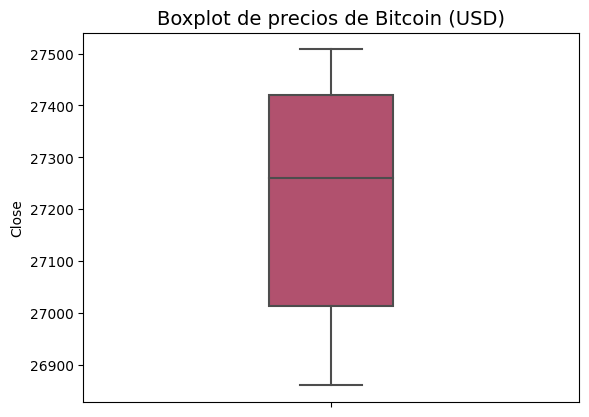

In [22]:
df = pd.DataFrame(df_bitcoin_quartiles()["Close"])
sns.boxplot(y='Close', data=df, orient='v', palette= "flare", whis=2, width=0.25)
plt.title('Boxplot de precios de Bitcoin (USD)', fontsize=14);

#6. Crear funcion Toma de desiciones

In [12]:
 def tomar_decisiones():

    precio_actual = extraer_tendencias()[0]
    tendencia = extraer_tendencias()[1]
    media_bitcoin = df_bitcoin_quartiles()['Close'].mean()
    
    # Aplicar el criterio de decisión
    if precio_actual >= media_bitcoin and tendencia == 'Baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'Alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    
    return algoritmo_decision

#7. Visualizacion

In [ ]:
def visualizacion():

  fig, ax = plt.subplots(figsize = (15,5))
  ax = df_bitcoin()["Close"].plot(fontsize = 14)

  # trazar una línea con el valor medio
  ax.axhline(y=np.mean(df_bitcoin()["Close"]), ls = "--", color="red")

   # Colocar titulos a la grafica

  ax.set_title("Valor Bitcoin", fontsize = 20)
  ax.set_ylabel("Bitcoin USD", fontsize = 16)
  ax.set_xlabel("Dias", fontsize = 16);

  # mostrar la decisión del algoritmo_decision

  plt.annotate(f"Resultado: {tomar_decisiones()}", xy=(df_bitcoin().index[-1],df_bitcoin()["Close"][-1]), 
                xytext=(-180, -150),textcoords='offset points', fontsize=15, color='gray')

   # mostrar el gráfico
  return plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


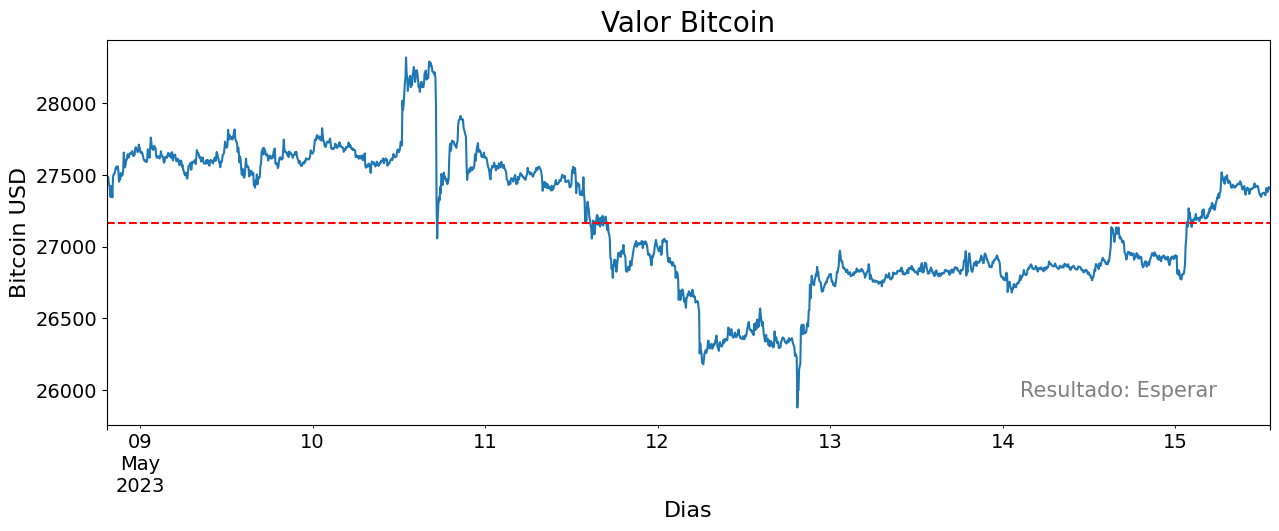

In [ ]:
visualizacion();

#8. Automatizacion

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

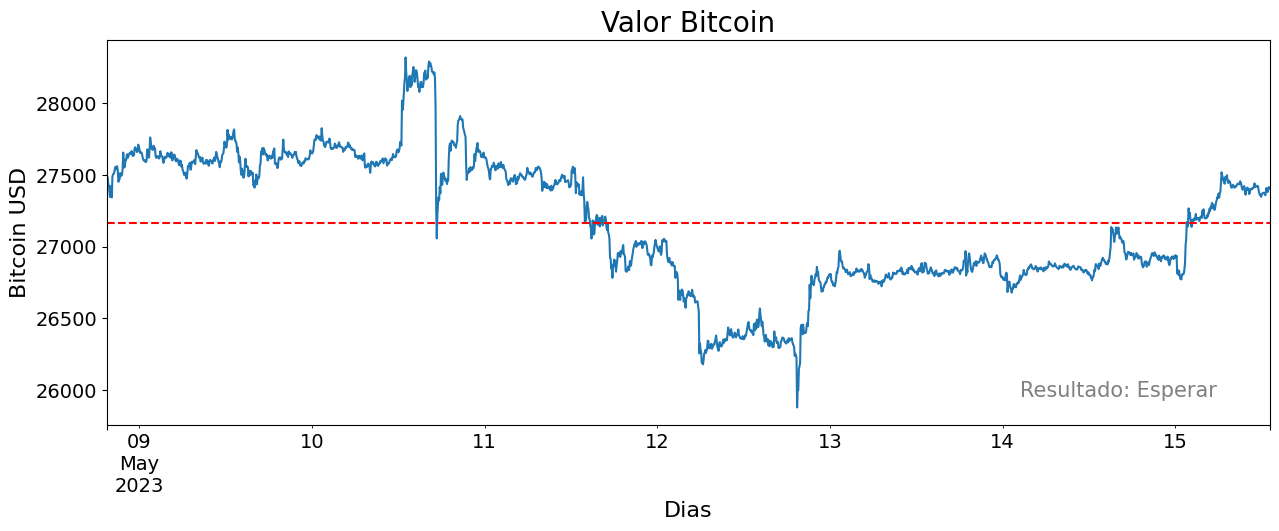

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import clear_output
import time

while(True):
  clear_output()
  df_bitcoin()
  extraer_tendencias()
  df_bitcoin_limpio()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)